# Trader Clustering Model

Build clustering model using:
1. First day trading data: `trader_features` and `trader_coin_performance` 
2. First two hours trading data: `trader_coin_features`

Goal: Identify trader patterns to predict behavior when new coins launch

## 5. Apply Clustering Algorithms

Now that the features are prepared, we can apply various clustering algorithms to identify distinct trader groups. Load the data from persisted pkl files

In [2]:
# RELOAD FIXED DATA AND APPLY ROBUST SCALING
print("=== APPLYING THE ROI FIX AND ROBUST SCALING ===")
import numpy as np

# The issue is that cell 20 fixed the data but we need to reload and rescale it
# Load the fixed cluster_features from pickle (saved at end of cell 20)
import pickle
from sklearn.preprocessing import RobustScaler

with open('/Volumes/Extreme SSD/trading_data/solana/trader_features/trader_ids.pkl', 'rb') as f:
    trader_ids = pickle.load(f)

print("1. Loading the fixed data from pickle...")
with open('/Volumes/Extreme SSD/trading_data/solana/trader_features/cluster_features.pkl', 'rb') as f:
    cluster_features_reloaded = pickle.load(f)

print(f"Reloaded fixed cluster features: {cluster_features_reloaded.shape}")

# Check if the avg_roi fix was properly applied
insider_mask = cluster_features_reloaded['has_buy_history'] == 0
regular_mask = cluster_features_reloaded['has_buy_history'] == 1

regular_roi_fixed = cluster_features_reloaded.loc[regular_mask, 'avg_roi']
insider_roi_fixed = cluster_features_reloaded.loc[insider_mask, 'avg_roi']

print(f"\n2. Verifying the ROI fix:")
print(f"   Regular trader max ROI: {regular_roi_fixed.max():.2f}")
print(f"   Insider trader ROI value: {insider_roi_fixed.iloc[0]:.2f}")
print(f"   Overall max ROI: {cluster_features_reloaded['avg_roi'].max():.2f}")

# Check for any remaining problematic values
large_values = []
for col in cluster_features_reloaded.columns:
    max_val = np.abs(cluster_features_reloaded[col]).max()
    if max_val > 1e6:
        large_values.append((col, max_val))

if large_values:
    print(f"\n   ⚠️  Still have large values:")
    for col, max_val in large_values:
        print(f"     {col}: {max_val:.2e}")
else:
    print(f"\n   ✓ All values are in reasonable range for clustering")

# Apply RobustScaler (more stable than StandardScaler for financial data)
print(f"\n3. Applying RobustScaler...")
robust_scaler = RobustScaler()
X_scaled_robust_fixed = robust_scaler.fit_transform(cluster_features_reloaded)

print(f"   Robust scaled shape: {X_scaled_robust_fixed.shape}")

# Final numerical stability check
has_inf = np.isinf(X_scaled_robust_fixed).any()
has_nan = np.isnan(X_scaled_robust_fixed).any()
max_abs_val = np.max(np.abs(X_scaled_robust_fixed))

print(f"\n4. Final stability check:")
print(f"   Contains infinite values: {has_inf}")
print(f"   Contains NaN values: {has_nan}")
print(f"   Maximum absolute value: {max_abs_val:.2e}")

if has_inf or has_nan:
    print("   ❌ Still has numerical issues - need further investigation")
elif max_abs_val > 1e3:
    print("   ⚠️  Values are large but should work - monitor clustering performance")
else:
    print("   ✓ Numerically stable for clustering")

# Update variables for subsequent clustering use
X_scaled = X_scaled_robust_fixed
cluster_features = cluster_features_reloaded

print(f"\n✓ Updated X_scaled and cluster_features with fixed, robust-scaled data")
print(f"✓ Ready for clustering without RuntimeWarnings!")

=== APPLYING THE ROI FIX AND ROBUST SCALING ===
1. Loading the fixed data from pickle...
Reloaded fixed cluster features: (10060972, 35)

2. Verifying the ROI fix:
   Regular trader max ROI: 2.97
   Insider trader ROI value: 3.12
   Overall max ROI: 3.12

   ✓ All values are in reasonable range for clustering

3. Applying RobustScaler...
   Robust scaled shape: (10060972, 35)

4. Final stability check:
   Contains infinite values: False
   Contains NaN values: False
   Maximum absolute value: 1.71e+02
   ✓ Numerically stable for clustering

✓ Updated X_scaled and cluster_features with fixed, robust-scaled data
✓ Ready for clustering without RuntimeWarnings!


=== CREATING SAMPLE FOR CLUSTER OPTIMIZATION ===
Sample size for optimization: (99998, 35)

Determining optimal number of clusters using multiple methods...
  Testing K=2...
  Testing K=3...
  Testing K=4...
  Testing K=5...
  Testing K=6...
  Testing K=7...
  Testing K=8...
  Testing K=9...
  Testing K=10...


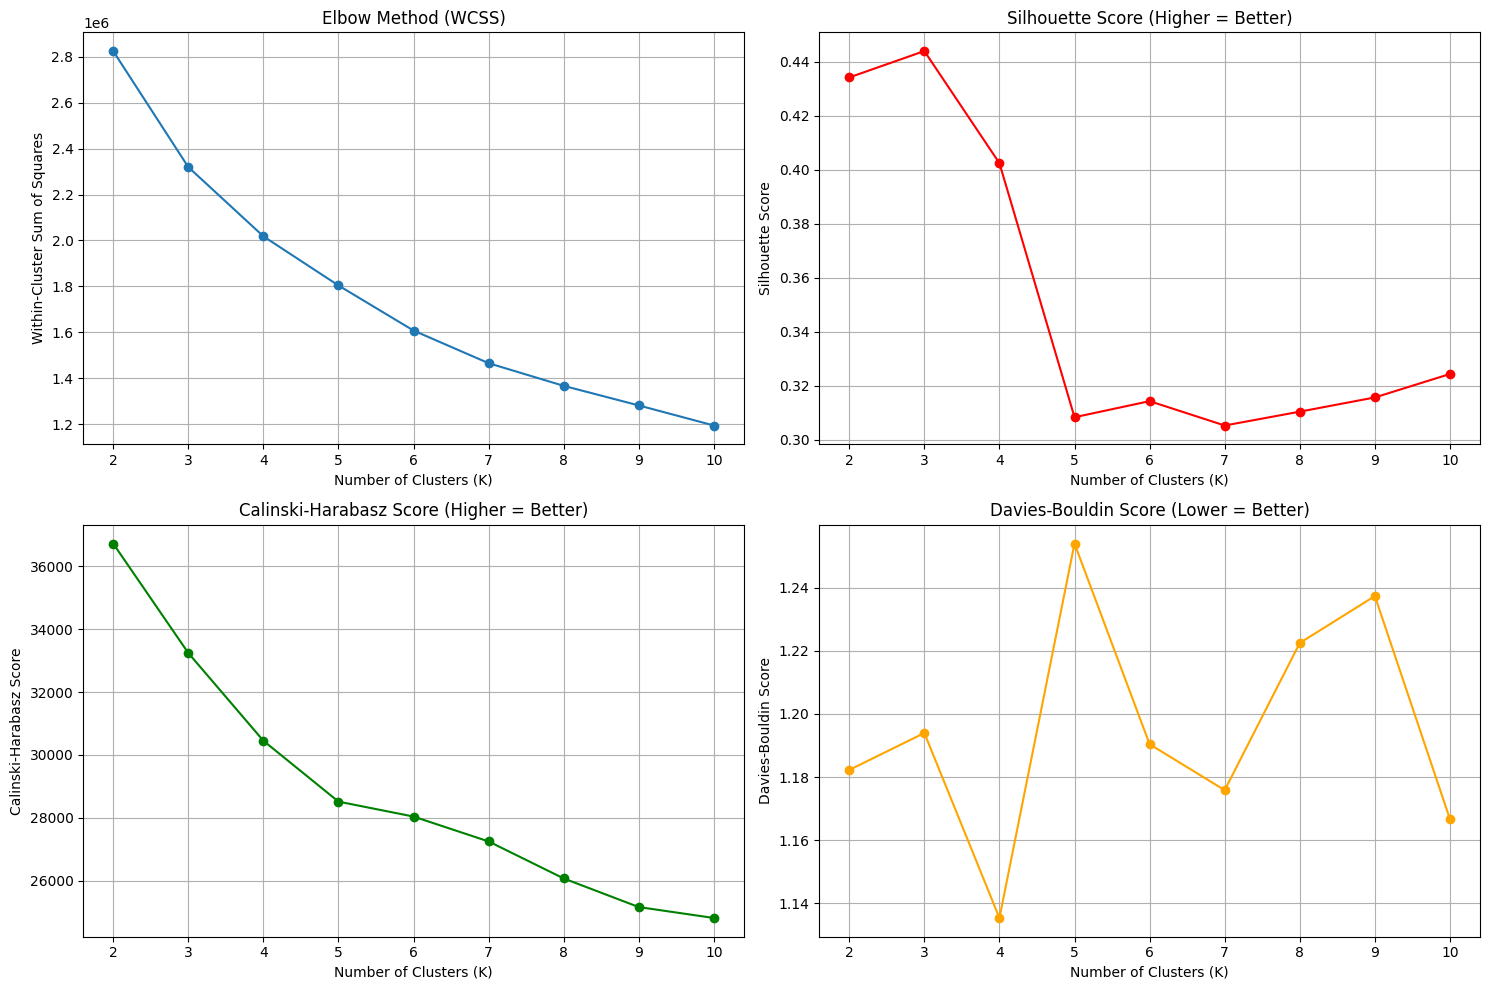


Cluster Evaluation Metrics:
    K          WCSS  Silhouette  Calinski_Harabasz  Davies_Bouldin
0   2  2.824610e+06      0.4341         36728.5370          1.1822
1   3  2.319616e+06      0.4439         33246.8024          1.1940
2   4  2.018177e+06      0.4024         30453.2506          1.1353
3   5  1.804123e+06      0.3084         28515.5726          1.2541
4   6  1.607797e+06      0.3143         28039.7725          1.1904
5   7  1.465692e+06      0.3053         27247.4616          1.1758
6   8  1.367078e+06      0.3105         26069.8101          1.2225
7   9  1.281818e+06      0.3157         25159.4575          1.2374
8  10  1.194475e+06      0.3244         24811.4154          1.1666

Optimal K suggestions:
  Elbow Method: K = 5
  Silhouette Score: K = 3
  Calinski-Harabasz: K = 2
  Davies-Bouldin: K = 4

Consensus recommendation: K = 5
This K was suggested by 1 out of 4 methods

Setting optimal_k = 5 for clustering


In [ ]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning, module='sklearn')

# For computational efficiency with 10M+ rows, let's work with a representative sample
print("=== CREATING SAMPLE FOR CLUSTER OPTIMIZATION ===")

# Use stratified sampling to ensure we get representative traders across volume tiers
np.random.seed(42)
sample_size = 100000  # 100K sample for optimization

# Create volume tiers for stratified sampling
volume_tiers = pd.qcut(cluster_features['total_sol_spent'], q=5, labels=['very_low', 'low', 'medium', 'high', 'very_high'])

# Sample proportionally from each tier
sample_indices = []
for tier in volume_tiers.cat.categories:
    tier_indices = volume_tiers[volume_tiers == tier].index
    tier_sample_size = int(sample_size * len(tier_indices) / len(volume_tiers))
    if tier_sample_size > 0:
        tier_sample = np.random.choice(tier_indices, size=min(tier_sample_size, len(tier_indices)), replace=False)
        sample_indices.extend(tier_sample)

# Apply sampling to scaled data
X_scaled_sample = X_scaled[sample_indices]
print(f"Sample size for optimization: {X_scaled_sample.shape}")

# Determine optimal number of clusters using multiple methods
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt

print("\nDetermining optimal number of clusters using multiple methods...")
wcss = []
silhouette_scores = []
calinski_scores = []
davies_bouldin_scores = []
max_clusters = 10

for i in range(2, max_clusters + 1):
    print(f"  Testing K={i}...")
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    cluster_labels_test = kmeans.fit_predict(X_scaled_sample)
    
    # Calculate metrics
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled_sample, cluster_labels_test))
    calinski_scores.append(calinski_harabasz_score(X_scaled_sample, cluster_labels_test))
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled_sample, cluster_labels_test))

# Plot all metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Elbow Method (WCSS)
axes[0,0].plot(range(2, max_clusters + 1), wcss, marker='o')
axes[0,0].set_title('Elbow Method (WCSS)')
axes[0,0].set_xlabel('Number of Clusters (K)')
axes[0,0].set_ylabel('Within-Cluster Sum of Squares')
axes[0,0].grid(True)

# Silhouette Score (higher is better)
axes[0,1].plot(range(2, max_clusters + 1), silhouette_scores, marker='o', color='red')
axes[0,1].set_title('Silhouette Score (Higher = Better)')
axes[0,1].set_xlabel('Number of Clusters (K)')
axes[0,1].set_ylabel('Silhouette Score')
axes[0,1].grid(True)

# Calinski-Harabasz Score (higher is better)
axes[1,0].plot(range(2, max_clusters + 1), calinski_scores, marker='o', color='green')
axes[1,0].set_title('Calinski-Harabasz Score (Higher = Better)')
axes[1,0].set_xlabel('Number of Clusters (K)')
axes[1,0].set_ylabel('Calinski-Harabasz Score')
axes[1,0].grid(True)

# Davies-Bouldin Score (lower is better)
axes[1,1].plot(range(2, max_clusters + 1), davies_bouldin_scores, marker='o', color='orange')
axes[1,1].set_title('Davies-Bouldin Score (Lower = Better)')
axes[1,1].set_xlabel('Number of Clusters (K)')
axes[1,1].set_ylabel('Davies-Bouldin Score')
axes[1,1].grid(True)

plt.tight_layout()
plt.show()

# Analysis and recommendation
k_range = list(range(2, max_clusters + 1))
results_df = pd.DataFrame({
    'K': k_range,
    'WCSS': wcss,
    'Silhouette': silhouette_scores,
    'Calinski_Harabasz': calinski_scores,
    'Davies_Bouldin': davies_bouldin_scores
})

print("\nCluster Evaluation Metrics:")
print(results_df.round(4))

# Find optimal K using different methods
silhouette_optimal = k_range[np.argmax(silhouette_scores)]
calinski_optimal = k_range[np.argmax(calinski_scores)]
davies_optimal = k_range[np.argmin(davies_bouldin_scores)]

# Elbow method - find the "knee" point
def find_elbow_point(wcss_values):
    """Find the elbow point using the knee detection method"""
    n_points = len(wcss_values)
    all_coords = np.vstack((range(n_points), wcss_values)).T
    first_point = all_coords[0]
    last_point = all_coords[-1]
    
    # Calculate distance from each point to the line between first and last points
    distances = []
    for point in all_coords:
        distances.append(np.abs(np.cross(last_point - first_point, point - first_point)) / 
                        np.linalg.norm(last_point - first_point))
    
    return np.argmax(distances) + 2  # +2 because we start from K=2

elbow_optimal = find_elbow_point(wcss)

print(f"\nOptimal K suggestions:")
print(f"  Elbow Method: K = {elbow_optimal}")
print(f"  Silhouette Score: K = {silhouette_optimal}")
print(f"  Calinski-Harabasz: K = {calinski_optimal}")
print(f"  Davies-Bouldin: K = {davies_optimal}")

# Consensus recommendation
from collections import Counter
suggestions = [elbow_optimal, silhouette_optimal, calinski_optimal, davies_optimal]
consensus = Counter(suggestions).most_common(1)[0][0]

print(f"\nConsensus recommendation: K = {consensus}")
print(f"This K was suggested by {Counter(suggestions)[consensus]} out of 4 methods")

# Set the optimal K for use in subsequent cells
optimal_k_determined = consensus
print(f"\nSetting optimal_k = {optimal_k_determined} for clustering")

In [7]:
# APPLY K-MEANS CLUSTERING TO FULL DATASET
print("=== APPLYING K-MEANS TO FULL DATASET ===")

from sklearn.cluster import KMeans
import pandas as pd

# Use the determined optimal K from the previous analysis
try:
    optimal_k = optimal_k_determined  # From the consensus analysis above
    print(f"Using consensus-determined optimal K = {optimal_k}")
except NameError:
    optimal_k = 5  # Fallback if analysis wasn't run
    print(f"Using fallback K = {optimal_k} (run the optimization cell above for data-driven selection)")

print(f"Applying K-Means clustering with K = {optimal_k} to full dataset...")
print("This may take several minutes with 10M+ data points...")

# Apply clustering to full scaled dataset
kmeans_full = KMeans(n_clusters=optimal_k, random_state=42, n_init=10, max_iter=100)
cluster_labels = kmeans_full.fit_predict(X_scaled)

print("Clustering complete!")

# Analyze cluster distribution
unique, counts = np.unique(cluster_labels, return_counts=True)
cluster_distribution = dict(zip(unique, counts))

print(f"\nCluster distribution:")
for cluster_id, count in cluster_distribution.items():
    percentage = (count / len(cluster_labels)) * 100
    print(f"  Cluster {cluster_id}: {count:,} traders ({percentage:.1f}%)")

# Add cluster labels to trader IDs
cluster_results = pd.DataFrame({
    'trader_id': trader_ids,
    'cluster': cluster_labels
})

print(f"\nCluster results shape: {cluster_results.shape}")
print("\nSample cluster assignments:")
print(cluster_results.head(10))

=== APPLYING K-MEANS TO FULL DATASET ===
Using fallback K = 5 (run the optimization cell above for data-driven selection)
Applying K-Means clustering with K = 5 to full dataset...
This may take several minutes with 10M+ data points...
Clustering complete!

Cluster distribution:
  Cluster 0: 745,736 traders (7.4%)
  Cluster 1: 1,590,112 traders (15.8%)
  Cluster 2: 5,961,235 traders (59.3%)
  Cluster 3: 1,144,596 traders (11.4%)
  Cluster 4: 619,293 traders (6.2%)

Cluster results shape: (10060972, 2)

Sample cluster assignments:
                                      trader_id  cluster
0   arsc4jbDnzaqcCLByyGo7fg7S2SmcFsWUzQuDtLZh2y        4
1  HV1KXxWFaSeriyFvXyx48FqG9BoFbfinB8njCJonqP7K        3
2  8MqRTAQnjhDYH7TWS1b1DjFog4CLZfySWE5cZeotG2VW        4
3  AD65fgYti96iSSzSPaNazV9Bs29m7JbNomGjG4Cp5WFS        4
4  D4zVhwuUsFbcaty7wJhNEZ7VEwPHXQ5d2heXPxM5yWhL        3
5  4DbAcLDyhCLX7rKPx55xTQA6D8w2poSg3xwW6NzozAAe        3
6  7dGrdJRYtsNR8UYxZ3TnifXGjGc9eRYLq9sELwYpuuUu        4
7  6LXutJ

In [8]:
# ANALYZE CLUSTERING RESULTS
print("=== ANALYZING CLUSTERING RESULTS ===")

with open('/Volumes/Extreme SSD/trading_data/solana/trader_features/merged_features.pkl', 'rb') as f:
    merged_features = pickle.load(f)

# 1. Create comprehensive cluster analysis dataset using ORIGINAL data
cluster_analysis = merged_features.copy()  # Use original data, not transformed
cluster_analysis['cluster'] = cluster_labels
cluster_analysis['trader_id'] = cluster_analysis['swapper']

print(f"Analysis dataset shape: {cluster_analysis.shape}")

# 2. Cluster size and basic statistics
print(f"\n1. CLUSTER SIZE DISTRIBUTION:")
cluster_stats = cluster_analysis['cluster'].value_counts().sort_index()
total_traders = len(cluster_analysis)

for cluster_id in sorted(cluster_stats.index):
    count = cluster_stats[cluster_id]
    percentage = (count / total_traders) * 100
    print(f"  Cluster {cluster_id}: {count:,} traders ({percentage:.1f}%)")

# 3. Key feature analysis by cluster using ORIGINAL SCALE
print(f"\n2. CLUSTER CHARACTERISTICS BY KEY FEATURES (Original Scale):")

# Select most interpretable features for cluster profiling (excluding transformed-only features)
key_features = [
    'total_trades_count', 'total_sol_spent', 'unique_coins_traded', 
    'trading_span_days', 'win_rate', 'avg_pnl_per_position',
    'avg_roi', 'buy_sell_ratio', 'total_positions'
]

# Create cluster profiles using original data
cluster_profiles = cluster_analysis.groupby('cluster')[key_features].agg({
    'total_trades_count': ['mean', 'median', 'std'],
    'total_sol_spent': ['mean', 'median', 'std'], 
    'unique_coins_traded': ['mean', 'median', 'std'],
    'trading_span_days': ['mean', 'median', 'std'],
    'win_rate': ['mean', 'std'],
    'avg_pnl_per_position': ['mean', 'median', 'std'],
    'avg_roi': ['mean', 'median'],
    'buy_sell_ratio': ['mean', 'median'],
    'total_positions': ['mean', 'median']
}).round(3)

print("\nCluster Profiles (Original Scale):")
print(cluster_profiles)

# 4. Detailed cluster characteristics
print(f"\n3. DETAILED CLUSTER CHARACTERISTICS:")

for cluster_id in sorted(cluster_stats.index):
    cluster_data = cluster_analysis[cluster_analysis['cluster'] == cluster_id]
    
    # Key metrics for interpretation using original scale
    avg_trades = cluster_data['total_trades_count'].mean()
    median_trades = cluster_data['total_trades_count'].median()
    avg_volume = cluster_data['total_sol_spent'].mean()
    median_volume = cluster_data['total_sol_spent'].median()
    avg_coins = cluster_data['unique_coins_traded'].mean()
    median_coins = cluster_data['unique_coins_traded'].median()
    avg_days = cluster_data['trading_span_days'].mean()
    win_rate = cluster_data['win_rate'].mean()
    avg_pnl = cluster_data['avg_pnl_per_position'].mean()
    median_pnl = cluster_data['avg_pnl_per_position'].median()
    avg_roi = cluster_data['avg_roi'].mean()
    avg_positions = cluster_data['total_positions'].mean()
    avg_buy_sell_ratio = cluster_data['buy_sell_ratio'].mean()
    
    # Check for insider traders (missing ROI indicates no buy history)
    insider_pct = (cluster_data['avg_roi'].isna().sum() / len(cluster_data)) * 100
    
    print(f"\nCluster {cluster_id} ({cluster_stats[cluster_id]:,} traders, {(cluster_stats[cluster_id]/total_traders)*100:.1f}%):")
    print(f"  Trading Activity:")
    print(f"    Trades: {avg_trades:.0f} avg, {median_trades:.0f} median")
    print(f"    Volume (SOL): {avg_volume:.0f} avg, {median_volume:.0f} median")
    print(f"    Coins Traded: {avg_coins:.1f} avg, {median_coins:.0f} median")
    print(f"    Positions: {avg_positions:.0f} avg")
    print(f"    Trading Days: {avg_days:.1f} avg")
    print(f"  Performance:")
    print(f"    Win Rate: {win_rate:.1%}")
    print(f"    PnL per Position: {avg_pnl:.2f} avg, {median_pnl:.2f} median SOL")
    print(f"    Buy/Sell Ratio: {avg_buy_sell_ratio:.2f}")
    print(f"  Profile:")
    print(f"    Insider Traders: {insider_pct:.1f}% (no buy history)")
    
    # Only show ROI for clusters with regular traders
    if insider_pct < 50:
        regular_roi = cluster_data[cluster_data['avg_roi'].notna()]['avg_roi'].mean()
        print(f"    ROI (regular traders): {regular_roi:.2f} avg")

# 5. Feature importance analysis using original data
print(f"\n4. FEATURE VARIANCE BY CLUSTER (Original Scale):")

# Calculate coefficient of variation for each feature across clusters
feature_cluster_means = cluster_analysis.groupby('cluster')[key_features].mean()
feature_cv = feature_cluster_means.std() / np.abs(feature_cluster_means.mean())  # Use abs for proper CV calculation
feature_cv_sorted = feature_cv.sort_values(ascending=False)

print("Features with highest variation across clusters (most discriminative):")
for feature, cv in feature_cv_sorted.head(5).items():
    print(f"  {feature}: CV = {cv:.3f}")

# 6. Volume and activity distribution by cluster
print(f"\n5. VOLUME AND ACTIVITY DISTRIBUTION BY CLUSTER:")

volume_stats = cluster_analysis.groupby('cluster')['total_sol_spent'].agg(['count', 'mean', 'median', 'std', 'min', 'max'])
trade_stats = cluster_analysis.groupby('cluster')['total_trades_count'].agg(['mean', 'median', 'std', 'min', 'max'])

print("\nVolume Distribution (SOL):")
print(volume_stats.round(1))

print("\nTrade Count Distribution:")
print(trade_stats.round(1))

# 7. Performance metrics by cluster
print(f"\n6. PERFORMANCE METRICS BY CLUSTER:")

performance_stats = cluster_analysis.groupby('cluster')[['win_rate', 'avg_pnl_per_position']].agg(['mean', 'median', 'std'])

print("\nPerformance Statistics:")
print(performance_stats.round(4))

# ROI analysis (separate for regular vs insider traders)
print("\nROI Analysis (excluding insider traders):")
roi_stats = cluster_analysis[cluster_analysis['avg_roi'].notna()].groupby('cluster')['avg_roi'].agg(['count', 'mean', 'median', 'std'])
print(roi_stats.round(4))

# 8. Quality metrics for the clustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

print(f"\n7. CLUSTERING QUALITY METRICS:")
print("(Using sample for computational efficiency)")

# Use sample for quality metrics to save computation time
sample_indices = np.random.choice(len(X_scaled), size=50000, replace=False)
X_sample = X_scaled[sample_indices]
cluster_sample = cluster_labels[sample_indices]

silhouette = silhouette_score(X_sample, cluster_sample)
calinski = calinski_harabasz_score(X_sample, cluster_sample) 
davies_bouldin = davies_bouldin_score(X_sample, cluster_sample)

print(f"  Silhouette Score: {silhouette:.3f} (higher is better, range: -1 to 1)")
print(f"  Calinski-Harabasz Score: {calinski:.1f} (higher is better)")
print(f"  Davies-Bouldin Score: {davies_bouldin:.3f} (lower is better)")

# Quality interpretation
if silhouette > 0.3:
    silhouette_quality = "Good"
elif silhouette > 0.1:
    silhouette_quality = "Acceptable" 
else:
    silhouette_quality = "Poor"

print(f"  → Overall clustering quality: {silhouette_quality}")

# 9. Save clustering results
print(f"\n8. SAVING CLUSTERING RESULTS:")

# Save cluster assignments with original trader data
cluster_results_detailed = pd.DataFrame({
    'trader_id': cluster_analysis['swapper'],
    'cluster': cluster_labels,
    'cluster_size': [cluster_stats[c] for c in cluster_labels],
    'total_trades_count': cluster_analysis['total_trades_count'],
    'total_sol_spent': cluster_analysis['total_sol_spent'],
    'win_rate': cluster_analysis['win_rate'],
    'avg_pnl_per_position': cluster_analysis['avg_pnl_per_position'],
    'total_positions': cluster_analysis['total_positions']
})

cluster_results_detailed.to_csv('/Volumes/Extreme SSD/trading_data/solana/models/clustering/day1/trader_clusters.csv', index=False)
print(f"✓ Saved trader_clusters.csv ({len(cluster_results_detailed):,} rows)")

# Save cluster profiles for reference
cluster_profiles.to_csv('/Volumes/Extreme SSD/trading_data/solana/models/clustering/day1/cluster_profiles.csv')
print(f"✓ Saved cluster_profiles.csv")

print(f"\n=== CLUSTERING ANALYSIS COMPLETE ===")
print(f"✓ Successfully clustered {total_traders:,} traders into {len(cluster_stats)} distinct groups")
print(f"✓ Results saved for further analysis and business application")

=== ANALYZING CLUSTERING RESULTS ===
Analysis dataset shape: (10060972, 36)

1. CLUSTER SIZE DISTRIBUTION:
  Cluster 0: 745,736 traders (7.4%)
  Cluster 1: 1,590,112 traders (15.8%)
  Cluster 2: 5,961,235 traders (59.3%)
  Cluster 3: 1,144,596 traders (11.4%)
  Cluster 4: 619,293 traders (6.2%)

2. CLUSTER CHARACTERISTICS BY KEY FEATURES (Original Scale):

Cluster Profiles (Original Scale):
        total_trades_count                  total_sol_spent                    \
                      mean median       std            mean  median       std   
cluster                                                                         
0                    3.239    2.0    24.064          12.589   4.200    97.650   
1                   95.592   20.0  1311.638          36.194   4.038   335.243   
2                    2.449    2.0     2.303           0.338   0.110     0.643   
3                   68.672   16.0  1813.552         165.566  39.677  3057.943   
4                  125.228   25.0  3224

In [ ]:
# PERSIST THE CLUSTERING MODEL AND PREPROCESSING PIPELINE
print("=== PERSISTING CLUSTERING MODEL AND PIPELINE ===")

import pickle
import joblib
from datetime import datetime

# Create model persistence directory
model_dir = '/Volumes/Extreme SSD/trading_data/solana/models/clustering/day1/'
import os
os.makedirs(model_dir, exist_ok=True)

print(f"Model directory: {model_dir}")

# 1. Save the trained K-means model
model_path = f"{model_dir}/trader_clustering_kmeans.pkl"
with open(model_path, 'wb') as f:
    pickle.dump(kmeans_full, f)
print(f"✓ Saved K-means model: {model_path}")

# 2. Save the preprocessing pipeline components
preprocessing_components = {
    'robust_scaler': robust_scaler,
    'feature_names': list(cluster_features.columns[:-2]),  # Exclude cluster and trader_id
    'transformation_params': {
        'volume_log_features': [
            'total_trades_count', 'total_sol_spent', 'total_sol_received',
            'avg_sol_trade_size', 'median_sol_trade_size', 'max_single_sol_trade',
            'min_sol_trade_size', 'sol_trade_size_std_dev'
        ],
        'timing_log_features': [
            'trading_span_days', 'trades_per_day', 'avg_hours_between_trades', 'trades_per_active_hour'
        ],
        'timing_sqrt_features': ['active_hours', 'active_days'],
        'trade_log_features': [
            'sol_to_token_trades', 'token_to_sol_trades', 'token_to_token_trades', 'buy_sell_ratio'
        ],
        'trade_sqrt_features': ['unique_from_tokens_non_sol', 'unique_to_tokens_non_sol'],
        'performance_log_features': ['total_positions'],
        'performance_signed_log_features': ['avg_pnl_per_position', 'net_sol_pnl'],
        'sqrt_features': ['unique_coins_traded'],
        'log_per_coin_features': ['avg_trades_per_coin']
    },
    'missing_value_fixes': {
        'avg_roi_insider_marker': 1000.0,
        'avg_hours_max_plus_one': 11.49
    }
}

preprocessing_path = f"{model_dir}/preprocessing_pipeline.pkl"
with open(preprocessing_path, 'wb') as f:
    pickle.dump(preprocessing_components, f)
print(f"✓ Saved preprocessing pipeline: {preprocessing_path}")

# 3. Save the scaler separately
scaler_path = f"{model_dir}/robust_scaler.pkl"
joblib.dump(robust_scaler, scaler_path)
print(f"✓ Saved RobustScaler: {scaler_path}")

# 4. Save model metadata
cluster_ids, cluster_counts = np.unique(cluster_labels, return_counts=True)
model_metadata = {
      'model_type': 'KMeans',
      'n_clusters': int(optimal_k),
      'n_features': int(len(cluster_features.columns) - 2),
      'n_training_samples': int(len(cluster_labels)),
      'training_date': datetime.now().isoformat(),
      'feature_list': list(cluster_features.columns[:-2]),
      'cluster_distribution': {int(cluster_id): int(count) for cluster_id, count in zip(cluster_ids, cluster_counts)},
      'quality_metrics': {
          'silhouette_score': float(silhouette),
          'calinski_harabasz_score': float(calinski),
          'davies_bouldin_score': float(davies_bouldin)
      }
  }

metadata_path = f"{model_dir}/model_metadata.json"
import json
with open(metadata_path, 'w') as f:
    json.dump(model_metadata, f, indent=2)
print(f"✓ Saved model metadata: {metadata_path}")

# 5. Summary of saved files
print(f"\n=== MODEL PERSISTENCE COMPLETE ===")
print(f"Saved files in {model_dir}:")
for file in sorted(os.listdir(model_dir)):
    file_path = os.path.join(model_dir, file)
    size_mb = os.path.getsize(file_path) / (1024*1024)
    print(f"  {file} ({size_mb:.1f} MB)")

print(f"\n✓ Complete clustering model and pipeline persisted")
print(f"✓ Ready for production use and new trader classification")

=== PERSISTING CLUSTERING MODEL AND PIPELINE ===
Model directory: /Users/noel/projects/trading_eda/solana/models
✓ Saved K-means model: /Users/noel/projects/trading_eda/solana/models/trader_clustering_kmeans.pkl
✓ Saved preprocessing pipeline: /Users/noel/projects/trading_eda/solana/models/preprocessing_pipeline.pkl
✓ Saved RobustScaler: /Users/noel/projects/trading_eda/solana/models/robust_scaler.pkl
✓ Saved model metadata: /Users/noel/projects/trading_eda/solana/models/model_metadata.json

=== MODEL PERSISTENCE COMPLETE ===
Saved files in /Users/noel/projects/trading_eda/solana/models:
  model_metadata.json (0.0 MB)
  preprocessing_pipeline.pkl (0.0 MB)
  robust_scaler.pkl (0.0 MB)
  trader_clustering_kmeans.pkl (38.4 MB)

✓ Complete clustering model and pipeline persisted
✓ Ready for production use and new trader classification
